In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from tqdm import tqdm

# XOR - Formulate

In [2]:
xor = {
      (0, 0): 0,
      (0, 1): 1,
      (1, 0): 1,
      (1, 1): 0,
       }

In [3]:
x = np.array([0, 1])
y = np.array([0, 1])

xi, yi = np.meshgrid(x, y)
xi = xi.flatten()
yi = yi.flatten()

z = np.array([xor.get((i, j)) for i, j in zip(xi, yi)])
# z = [xor(i, j) for i, j in ]

In [4]:
xi, yi, z

(array([0, 1, 0, 1]), array([0, 0, 1, 1]), array([0, 1, 1, 0]))

In [5]:
z == 0

array([ True, False, False,  True])

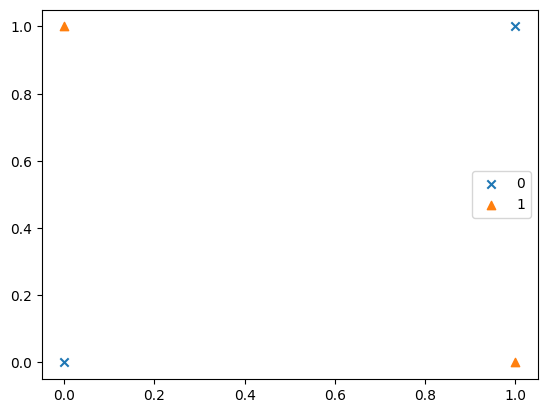

In [6]:
plt.scatter(xi[z == 0], yi[z == 0], marker="x")
plt.scatter(xi[z == 1], yi[z == 1], marker="^")
plt.legend(["0", "1"])
plt.show()

# Dataset

In [7]:
for i in zip(xi, yi):
  print(i)

(0, 0)
(1, 0)
(0, 1)
(1, 1)


In [8]:
np.stack([xi, yi], axis=-1)

array([[0, 0],
       [1, 0],
       [0, 1],
       [1, 1]])

In [22]:
class XORDataset(Dataset):
  def __init__(self):
    super().__init__()
    self.source = torch.Tensor([[0,0], [0,1], [1,0], [1,1]])
    self.target = torch.Tensor([0, 1, 1, 0]).view(-1,1)

  def __len__(self):
    return len(self.source)

  def __getitem__(self, index):
    torch.randn
    noise_ = torch.normal(0, 0.01, size=(2,))
    return self.source[index] + noise_, self.target[index]


In [23]:
dataset = XORDataset()

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Model define

In [24]:
class XOR(nn.Module):
  def __init__(self):
    super().__init__()

    self.stack = nn.Sequential(
        nn.Linear(2, 10),
        nn.Softplus(),
        nn.Linear(10, 1)
    )

  def forward(self, x):
    return self.stack(x)

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)

Device:  cuda


# Training loop

In [26]:
@torch.no_grad()
def xor_pred():
  x = np.arange(-0.5, 1.5, 0.01, dtype=np.float32)
  y = np.arange(-0.5, 1.5, 0.01, dtype=np.float32)

  xx, yy = np.meshgrid(x, y)

  # xx = xx.flatten()
  # yy = yy.flatten()

  xy = torch.from_numpy(np.stack([xx.flatten(), yy.flatten()], axis=-1)).to(device)
  pred = model(xy).sigmoid().to('cpu').numpy()
  zz = pred.reshape(xx.shape)
  return xx, yy, zz

In [27]:
model = XOR()
model.to(device)

optimizer = Adam(model.parameters())
crit = nn.BCEWithLogitsLoss().to(device)

In [28]:
def create_frame(step, ax):
    ax.cla()
    plt.contourf(xx, yy, zz)
    plt.scatter(xi[z == 0], yi[z == 0], marker="x", label='0')
    plt.scatter(xi[z == 1], yi[z == 1], marker="^", label='1')
    plt.legend()

In [29]:
n_epochs = 10_000

training_loss = []
contours = []
for epoch in tqdm(range(n_epochs)):
  epoch_loss = 0
  for source, target in dataloader:
    source = source.to(device)
    target = target.to(device)
    # forward pass
    logits = model(source)
    loss = crit(logits, target)

    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    epoch_loss += loss.item()
  contours.append(xor_pred())

  training_loss.append(epoch_loss/4)

100%|██████████| 10000/10000 [00:25<00:00, 388.47it/s]


In [30]:
with torch.no_grad():
  print(model(torch.Tensor([[0,0],[0,1], [1,0], [1,1]]).to(device)).sigmoid())

tensor([[2.7454e-05],
        [9.9998e-01],
        [9.9998e-01],
        [1.7495e-05]], device='cuda:0')


# Visualization and testing

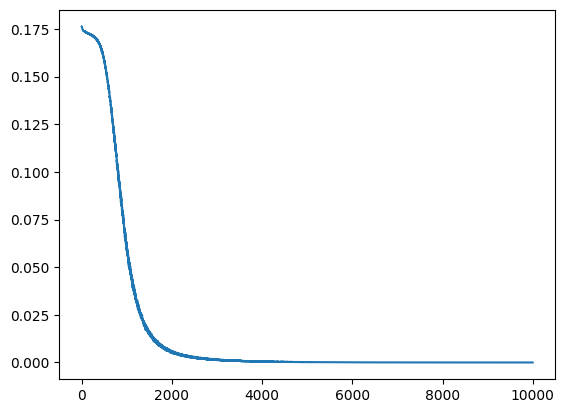

In [31]:
plt.plot(training_loss)

In [32]:
xx, yy, zz = contours[-1]

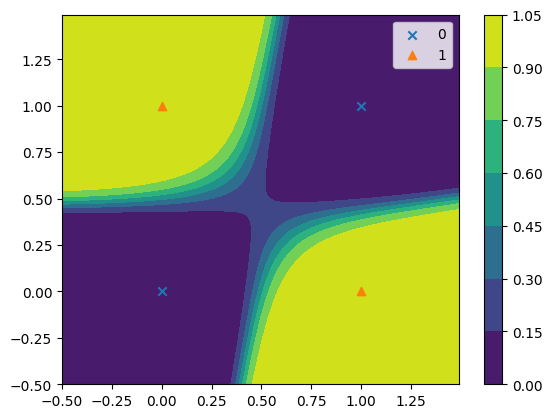

In [33]:
plt.figure()
plt.contourf(xx, yy, zz)
plt.colorbar()
plt.scatter(xi[z == 0], yi[z == 0], marker="x", label='0')
plt.scatter(xi[z == 1], yi[z == 1], marker="^", label='1')
plt.legend()
plt.show()

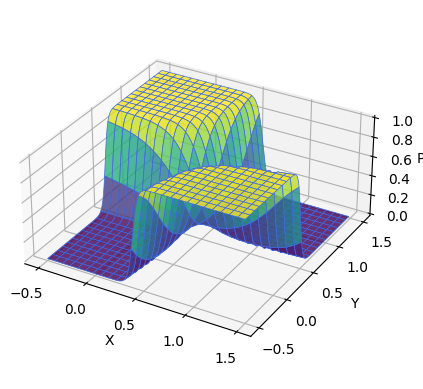

In [34]:
ax = plt.figure().add_subplot(projection='3d')

# Plot the 3D surface
ax.plot_surface(xx, yy, zz, edgecolor='royalblue', cmap='viridis', lw=0.5, rstride=8, cstride=8,
                alpha=0.8)

ax.set(xlim=(-0.5, 1.5), ylim=(-0.5, 1.5), zlim=(-0.5, 1.5),
       xlabel='X', ylabel='Y', zlabel='Pred')
plt.axis('image')
plt.show()
